# Source Counts

In [3]:
from choices import get_train_data
x = get_train_data()
print(x.columns.to_list())

offset:  	0.000|9.999
singinficance:  0.870|267.938
['class', 'gal_b2', 'gal_l2', 'hard_hs', 'hard_hm', 'hard_ms', 'var_inter_prob_b', 'var_inter_sigma_b', 'var_intra_prob_b', 'var_inter_index_b', 'kp_intra_prob_b', 'var_intra_index_b', 'h-csc', 'b-csc', 'm-csc', 's-csc', 'u-csc', '0p3_8_csc', 'FUV', 'NUV', 'u-sdss', 'g-sdss', 'r-sdss', 'i-sdss', 'z-sdss', 'W1', 'W2', 'W3', 'W4', '4.5 microns (IRAC)', '8.0 microns (IRAC)', '24 microns (MIPS)', 'J', 'H', 'K', '3.6 microns (IRAC)', '5.8 microns (IRAC)', 'G', 'Bp', 'Rp', 'B-R', 'G-J', 'G-W2', 'Bp-H', 'Bp-W3', 'Rp-K', 'J-H', 'J-W1', 'W1-W2']


# Feature details

In [4]:
import pandas as pd 
import numpy as np 
from utilities import deets 
from choices import param_dict
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
x.columns.to_list()

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________


['gal_b2',
 'gal_l2',
 'var_inter_prob_b',
 'var_inter_sigma_b',
 'var_intra_prob_b',
 'var_inter_index_b',
 'kp_intra_prob_b',
 'var_intra_index_b',
 'h-csc',
 'b-csc',
 'm-csc',
 's-csc',
 'u-csc',
 '0p3_8_csc',
 'FUV',
 'NUV',
 'u-sdss',
 'g-sdss',
 'r-sdss',
 'i-sdss',
 'z-sdss',
 'W1',
 'W2',
 'W3',
 'W4',
 '24_microns_(MIPS)',
 'J',
 'H',
 'K',
 'G',
 'Bp',
 'Rp',
 'B-R',
 'G-J',
 'G-W2',
 'Bp-H',
 'Bp-W3',
 'Rp-K',
 'J-H',
 'J-W1',
 'W1-W2']

In [12]:
deets(df , 1)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________


# Imputation comparison

In [89]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 
from IPython.display import display
from tqdm import tqdm_notebook
import tqdm
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import  IterativeImputer 
from sklearn.impute import SimpleImputer , KNNImputer
from sklearn.preprocessing import Normalizer
sns.set(font_scale=1.3, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':True} , style="whitegrid")

%load_ext autoreload
%autoreload 2

In [102]:
from utilities import get_score
fname =  f'temp_res_comp/train_prob/mode_GB.csv'
df = pd.read_csv(fname)
temp = get_score([df] , k=10 , sc_average = 'macro')
d1 = temp['class_scores']

fname =  f'temp_res_comp/train_prob/10iter_rfimp_GB.csv'
df = pd.read_csv(fname)
temp = get_score([df] , k=10 , sc_average = 'macro')
d2 = temp['class_scores']

df = pd.concat([d1,d2] , axis=1 , names=['Mode' , 'Iterative Regression'] , levels= ['Mode' , 'Iterative Regression'])
df.to_csv('temp.csv' , float_format='%.2f')

# Gamma Tuning

In [77]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

In [78]:
import joblib 
gamma_tune_dict = joblib.load('../not_on_git/gamma_tune_dict.pkl')
gamma_tune_dict

{0.08: <__main__.make_model at 0x7fb275f74ba8>,
 0.09: <__main__.make_model at 0x7fb27d2dad30>,
 0.0: <__main__.make_model at 0x7fb2763c3940>,
 0.01: <__main__.make_model at 0x7fb276690c50>,
 0.02: <__main__.make_model at 0x7fb27c75a7f0>,
 0.03: <__main__.make_model at 0x7fb275f4b588>,
 0.04: <__main__.make_model at 0x7fb27d1a1588>,
 0.05: <__main__.make_model at 0x7fb27d795048>,
 0.06: <__main__.make_model at 0x7fb27d898e10>,
 0.07: <__main__.make_model at 0x7fb2767d2c88>,
 0.065: <__main__.make_model at 0x7fb276735eb8>,
 0.075: <__main__.make_model at 0x7fb2766cb198>,
 0.085: <__main__.make_model at 0x7fb27d8b5390>,
 0.0775: <__main__.make_model at 0x7fb27d1975f8>,
 0.0725: <__main__.make_model at 0x7fb276386be0>,
 0.1: <__main__.make_model at 0x7fb276664c88>,
 0.095: <__main__.make_model at 0x7fb27642c9e8>,
 0.0675: <__main__.make_model at 0x7fb27d8080f0>}

In [86]:

f1 , pres  , recall , mcc = []  , [] , [] , [] 
gamma = []
for el in gamma_tune_dict.keys():
    f1.append(gamma_tune_dict[el].result['f1'])
    pres.append(gamma_tune_dict[el].result['precision'])
    recall.append(gamma_tune_dict[el].result['recall'])
    mcc.append(gamma_tune_dict[el].result['mcc'])
    gamma.append(el)
gamma_score = pd.DataFrame({
    'gamma' : gamma ,
    'MCC' : mcc ,
    'precision' : pres , 
    'recall' : recall , 
    'f1 score' : f1 ,
}).sort_values(by='gamma').reset_index(drop=True)
gamma_score = gamma_score[gamma_score['gamma']<0.098]
gamma_score = gamma_score[gamma_score['gamma']!=0.0675]
#gamma_score =  gamma_score[gamma_score['gamma']>0.038]
gamma_score

,gamma,MCC,precision,recall,f1 score
0,0.0000,0.902354,0.825647,0.741914,0.775135
1,0.0100,0.903654,0.815030,0.744892,0.772984
2,0.0200,0.904010,0.814175,0.750969,0.777873
3,0.0300,0.908147,0.827579,0.773332,0.797430
4,0.0400,0.907496,0.807328,0.764431,0.783577
5,0.0500,0.905469,0.806781,0.771818,0.787540
6,0.0600,0.906925,0.812620,0.790910,0.800966
7,0.0650,0.906818,0.806899,0.788814,0.796865
9,0.0700,0.904211,0.795280,0.783880,0.788864
10,0.0725,0.904418,0.796098,0.788023,0.790790


In [92]:
gamma_score.iloc[[3 , 6,10]]

,gamma,MCC,precision,recall,f1 score
3,0.030,0.908147,0.827579,0.773332,0.797430
6,0.060,0.906925,0.812620,0.790910,0.800966
11,0.075,0.906057,0.800935,0.794440,0.796469


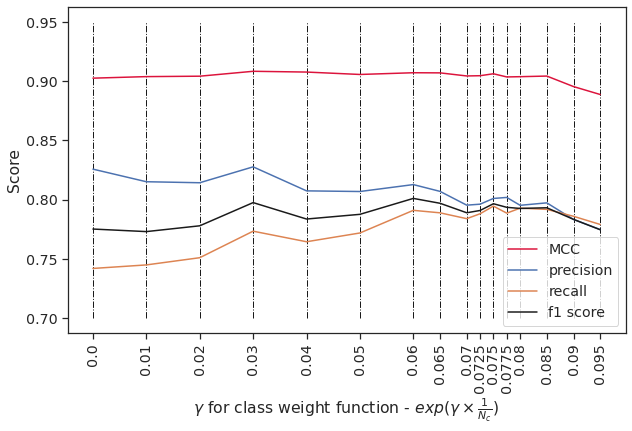

In [87]:
sns.set(font_scale=1.3, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':True} , style="ticks")
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(10,6))

ax.plot(gamma_score['gamma'] , gamma_score['MCC'] , label = 'MCC' , color='crimson')
ax.plot(gamma_score['gamma'] , gamma_score['precision'] , label = 'precision')
ax.plot(gamma_score['gamma'] , gamma_score['recall'] , label = 'recall') 
ax.plot(gamma_score['gamma'] , gamma_score['f1 score'] , label = 'f1 score' , color='k') 
ax.set_xticks(gamma_score['gamma'] , )
ax.set_xticklabels(gamma_score['gamma'], rotation=90)
ax.vlines(gamma_score['gamma'] , ymin = 0.7 , ymax=0.95 , linewidth=1 , color='k' , alpha=1, linestyle='-.')

#ax2 = ax.twinx()
ax.grid(False)
ax.set_xlabel(r'$\gamma$ for class weight function - $exp(\gamma\times\frac{1}{N_c} )$')
ax.set_ylabel('Score')
plt.legend()
plt.savefig('final_plots/gamma_tuning_02.jpg')
plt.show()

> TODO : model tuning for 0.06, and reerification

In [122]:
gamma_tune_dict[0.07].result

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2769
 AGN           2416
 YSO           1177
 HMXB           740
 ULX            210
 CV             157
 LMXB           122
 PULSAR         112,
 'balanced_accuracy': 0.7990135039182039,
 'accuracy': 0.9347007659353499,
 'precision': 0.8132076064780758,
 'recall': 0.7990135039182039,
 'f1': 0.805187821761211,
 'mcc': 0.911602433539088,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.974113         0.965646  0.969861
 CV          0.584337         0.617834  0.600619
 HMXB        0.913102         0.922973  0.918011
 LMXB        0.804196         0.942623  0.867925
 PULSAR      0.485149         0.437500  0.460094
 STAR        0.957348         0.964608  0.960964
 ULX         0.715640         0.719048  0.717340
 YSO         0.958225         0.935429  0.946690,
 'res

# Calculate scores

In [1]:
import pandas as pd 
import numpy as np 
from utilities import get_score

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938


In [16]:
df = pd.read_csv('temp_res_comp/train_prob/mode_GB.csv' , index_col='name')
#df = pd.read_csv('temp_res_comp/train_prob/mode_RF.csv' , index_col='name')
#df = pd.read_csv('temp_res_comp/train_prob/none_lightGBM.csv' , index_col='name')
df 

,true_class,pred_class,pred_prob,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J181044.4-260901,CV,PULSAR,0.494503,0.013341,0.393068,0.016631,0.007113,0.494503,0.044733,0.011582,0.019030
2CXO J104409.2-595904,YSO,YSO,0.781595,0.007102,0.032291,0.030874,0.011654,0.031463,0.087751,0.017270,0.781595
2CXO J224731.7+033549,AGN,PULSAR,0.360628,0.261291,0.057642,0.112283,0.009154,0.360628,0.028470,0.101648,0.068883
2CXO J053536.6-051850,STAR,STAR,0.909449,0.005718,0.039022,0.015799,0.010959,0.012286,0.909449,0.004848,0.001918
2CXO J201657.8-704703,ULX,PULSAR,0.479177,0.017152,0.394054,0.060770,0.014311,0.479177,0.016743,0.011379,0.006413
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J123613.4+275150,AGN,AGN,0.899162,0.899162,0.039616,0.005901,0.001148,0.001685,0.003309,0.048364,0.000816
2CXO J161436.5-223031,PULSAR,PULSAR,0.458746,0.005546,0.439247,0.018749,0.011930,0.458746,0.006238,0.055581,0.003963
2CXO J004142.9-091915,STAR,STAR,0.982564,0.005121,0.001937,0.008805,0.000297,0.000010,0.982564,0.001242,0.000024


In [17]:
get_score([df] , sc_average='macro')

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2633
 AGN           2184
 YSO           1182
 HMXB           786
 ULX            338
 CV             239
 PULSAR         196
 LMXB           145,
 'balanced_accuracy': 0.7951883707695815,
 'accuracy': 0.8908217577567181,
 'precision': 0.7099381876425648,
 'recall': 0.7951883707695815,
 'f1': 0.7404955122619998,
 'mcc': 0.8560587678459877,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.892693         0.978938  0.933828
 CV          0.620482         0.430962  0.508642
 HMXB        0.875668         0.833333  0.853977
 LMXB        0.804196         0.793103  0.798611
 PULSAR      0.554455         0.285714  0.377104
 STAR        0.915771         0.970376  0.942283
 ULX         0.758294         0.473373  0.582878
 YSO         0.939948         0.913706  0.926641}

# Feature Feature Correlation

# Missing features

In [13]:
import pandas as pd 
from matplotlib import pyplot as plt 

In [14]:
from utilities import deets 
from choices import param_dict

In [15]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


In [16]:
x_all = x.copy()
x_all.insert(0 , 'class' , y.to_list())
x_all

,class,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,m-csc,s-csc,u-csc,0p3_8_csc,FUV,NUV,u-sdss,g-sdss,r-sdss,i-sdss,z-sdss,W1,W2,W3,W4,24_microns_(MIPS),J,H,K,G,Bp,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2CXO J002359.4-720438,CV,2.487849,8.497420,2.632625,0.000904,5.046627,0.00,8.195828,1.0,1.499984e-09,0.000345,0.000446,0.000276,0.000140,0.000383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.664472,4.681118,4.784757,2.894845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J174041.4-534004,CV,4.327881,9.393618,9.999996,0.017956,1.995495,10.00,8.236122,0.0,1.102579e-07,0.054905,0.065857,0.040891,0.004881,0.071584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002409.2-720543,CV,2.488746,8.496825,9.999844,0.001090,6.298061,7.50,8.909807,1.0,8.495617e-10,0.001753,0.000648,0.001476,0.002739,0.001475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002411.1-720620,CV,2.489281,8.496673,8.302307,0.026969,8.383567,6.25,9.841010,2.0,9.022461e-10,0.004952,0.001471,0.002686,0.008907,0.009893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002401.4-720441,CV,2.487878,8.497314,5.005657,0.000442,7.272317,3.75,9.850364,2.0,1.416053e-09,0.000386,0.000579,0.000374,0.000131,0.000342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J003444.5-431554,AGN,0.888957,8.713766,NaN,NaN,3.074255,NaN,0.408315,0.0,NaN,0.010893,0.004661,0.005908,0.016989,0.005821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.084603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J203606.3+422737,YSO,5.054270,2.262789,NaN,NaN,3.363494,NaN,8.996703,0.0,NaN,0.006719,0.001328,0.002974,0.014401,0.006874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000842,8.170101,7.842090,2.210333,9.059976,8.763816,7.935403,4.953001,7.119828,NaN,6.445148,NaN,6.807378,5.048179,NaN,NaN
2CXO J131747.5+411745,AGN,9.176328,2.880393,NaN,NaN,1.768983,NaN,2.472603,0.0,9.654383e-08,0.044660,0.033835,0.040240,0.034558,0.038342,7.466017,7.974027,5.356182,8.365843,6.033698,7.713851,8.133347,7.457694,6.444994,6.607705,0.541792,NaN,NaN,NaN,NaN,8.314470,7.569368,8.002279,2.122574,NaN,5.055027,NaN,4.955872,NaN,NaN,NaN,6.731328


In [17]:
miss = []
for cl in y.unique():
#    cl = 'AGN'
    temp = x_all[x_all['class']==cl].drop(columns=['class'])
    miss.append((1-temp.isna().sum(axis=0) / len(temp)).to_frame(name=cl))
miss = pd.concat(miss , axis=1)
miss.insert(0 , 'overall' , (1-x.isna().sum(axis=0) / len(x)).to_list())
miss = miss[['overall' , 'AGN' , 'STAR' ,'YSO' , 'CV' , 'HMXB' , 'PULSAR'  , 'LMXB' ,'ULX']]

In [18]:
from choices import param_dict 
param_dict['inter-obs-var'] = ['var_inter_prob_b' , 'var_inter_sigma_b' , 'var_inter_index_b']
param_dict['intra-obs-var'] = ['var_intra_prob_b' , 'kp_intra_prob_b' , 'var_intra_index_b']
comb = ['WISE' , '2MASS' , 'GAIA' , 'SDSS' , 'GALEX' ,'inter-obs-var','intra-obs-var' ]
comb_df = []
for c in comb:
    comb_df.append(miss.loc[param_dict[c]].mean().to_frame(name=c).T)
comb_df = pd.concat(comb_df)
comb_df

,overall,AGN,STAR,YSO,CV,HMXB,PULSAR,LMXB,ULX
WISE,0.412307,0.768163,0.365591,0.225413,0.030120,0.044452,0.049505,0.076923,0.014218
2MASS,0.553507,0.263744,0.913262,0.854656,0.158635,0.071301,0.089109,0.048951,0.030016
GAIA,0.599766,0.605428,0.800358,0.583116,0.367470,0.167112,0.287129,0.181818,0.123223
SDSS,0.237648,0.705136,0.037419,0.000174,0.062651,0.022193,0.000000,0.000000,0.048341
GALEX,0.171881,0.492902,0.044624,0.000000,0.048193,0.002674,0.019802,0.034965,0.009479
inter-obs-var,0.496560,0.317745,0.547312,0.554395,0.481928,0.716578,0.495050,0.951049,0.464455
intra-obs-var,0.948851,0.986639,0.922222,0.947781,0.795181,0.965241,0.950495,0.874126,0.990521


In [19]:
sep_col = ['h-csc' ,'b-csc' , 'm-csc' , 'u-csc' ,'0p3_8_csc' ,'B-R' , 'G-J' , 'G-W2' , 'Bp-H' , 'Bp-W3' , 'Rp-K' , 'J-H' , 'J-W1' , 'W1-W2' , '24_microns_(MIPS)']
sep_df = miss.loc[sep_col]
sep_df

,overall,AGN,STAR,YSO,CV,HMXB,PULSAR,LMXB,ULX
h-csc,0.742568,0.774113,0.717563,0.634465,0.819277,0.838235,0.663366,0.923077,0.819905
b-csc,0.984811,0.993319,0.970609,0.997389,0.969880,0.990642,0.990099,0.986014,0.995261
m-csc,0.951707,0.972860,0.949462,0.904265,0.963855,0.967914,0.930693,0.888112,0.985782
u-csc,0.956900,0.985386,0.907168,0.994778,0.963855,0.982620,0.940594,0.986014,0.976303
0p3_8_csc,0.829417,0.850939,0.828315,0.794604,0.686747,0.882353,0.831683,0.601399,0.867299
B-R,0.599766,0.605428,0.800358,0.583116,0.367470,0.167112,0.287129,0.181818,0.123223
G-J,0.425159,0.209603,0.746595,0.542211,0.096386,0.048128,0.069307,0.034965,0.014218
G-W2,0.283786,0.531106,0.263799,0.119234,0.018072,0.032086,0.039604,0.048951,0.014218
Bp-H,0.425159,0.209603,0.746595,0.542211,0.096386,0.048128,0.069307,0.034965,0.014218
Bp-W3,0.284305,0.532359,0.264516,0.119234,0.018072,0.030749,0.039604,0.048951,0.014218


In [20]:
miss_comb_df = pd.concat([sep_df , comb_df]).sort_values(by='overall' , ascending=False)
miss_comb_df

,overall,AGN,STAR,YSO,CV,HMXB,PULSAR,LMXB,ULX
b-csc,0.984811,0.993319,0.970609,0.997389,0.969880,0.990642,0.990099,0.986014,0.995261
u-csc,0.956900,0.985386,0.907168,0.994778,0.963855,0.982620,0.940594,0.986014,0.976303
m-csc,0.951707,0.972860,0.949462,0.904265,0.963855,0.967914,0.930693,0.888112,0.985782
intra-obs-var,0.948851,0.986639,0.922222,0.947781,0.795181,0.965241,0.950495,0.874126,0.990521
0p3_8_csc,0.829417,0.850939,0.828315,0.794604,0.686747,0.882353,0.831683,0.601399,0.867299
h-csc,0.742568,0.774113,0.717563,0.634465,0.819277,0.838235,0.663366,0.923077,0.819905
B-R,0.599766,0.605428,0.800358,0.583116,0.367470,0.167112,0.287129,0.181818,0.123223
GAIA,0.599766,0.605428,0.800358,0.583116,0.367470,0.167112,0.287129,0.181818,0.123223
2MASS,0.553507,0.263744,0.913262,0.854656,0.158635,0.071301,0.089109,0.048951,0.030016
J-H,0.548488,0.248017,0.913262,0.854656,0.156627,0.070856,0.089109,0.048951,0.028436


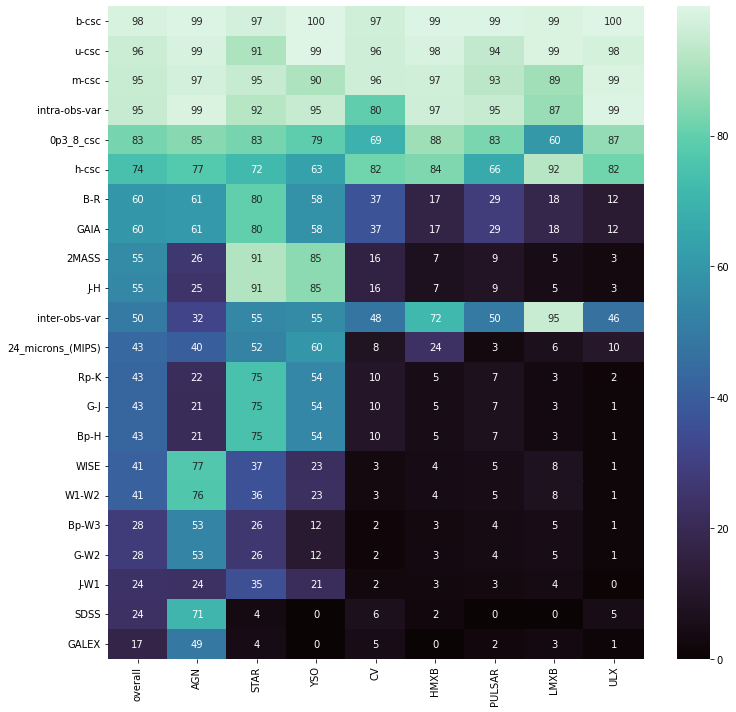

In [22]:
import seaborn as sns
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
sns.heatmap(miss_comb_df*100 , ax=ax , annot=True , fmt='.0f' , cmap='mako')
plt.xticks(rotation=90)
#plt.savefig('final_plots/missing_features.eps' , format='eps')
plt.savefig('final_plots/missing_features.jpg' , format='jpg')
plt.show()

In [43]:
print(miss.to_latex(float_format="%.2f" , longtable=False))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   CV &  STAR &  HMXB &  YSO &  ULX &  AGN &  LMXB &  PULSAR \\
\midrule
gal\_b2            & 0.00 &  0.00 &  0.00 & 0.00 & 0.00 & 0.00 &  0.00 &    0.00 \\
gal\_l2            & 0.00 &  0.00 &  0.00 & 0.00 & 0.00 & 0.00 &  0.00 &    0.00 \\
var\_inter\_prob\_b  & 0.52 &  0.45 &  0.28 & 0.45 & 0.54 & 0.68 &  0.05 &    0.50 \\
var\_inter\_sigma\_b & 0.52 &  0.45 &  0.28 & 0.45 & 0.54 & 0.68 &  0.05 &    0.50 \\
var\_intra\_prob\_b  & 0.20 &  0.08 &  0.03 & 0.05 & 0.01 & 0.01 &  0.13 &    0.05 \\
var\_inter\_index\_b & 0.52 &  0.45 &  0.28 & 0.45 & 0.54 & 0.68 &  0.05 &    0.50 \\
kp\_intra\_prob\_b   & 0.20 &  0.08 &  0.03 & 0.05 & 0.01 & 0.01 &  0.13 &    0.05 \\
var\_intra\_index\_b & 0.20 &  0.08 &  0.03 & 0.05 & 0.01 & 0.01 &  0.13 &    0.05 \\
h-csc             & 0.18 &  0.28 &  0.16 & 0.37 & 0.18 & 0.23 &  0.08 &    0.34 \\
b-csc             & 0.03 &  0.03 &  0.01 & 0.00 & 0.00 & 0.01 &  0.01 &    0.01 \\
m-csc             & 0.04 &  0.05 &  0

In [24]:
miss = []
for cl in y.unique():
    temp = x_all[x_all['class']==cl].drop(columns=['class'])
    x_all.isna().sum(axis=0) / len(x_all).to_df()

gal_b2               0.000000
gal_l2               0.000000
var_inter_prob_b     0.503440
var_inter_sigma_b    0.503440
var_intra_prob_b     0.051149
var_inter_index_b    0.503440
kp_intra_prob_b      0.051149
var_intra_index_b    0.051149
h-csc                0.257432
b-csc                0.015189
m-csc                0.048293
s-csc                0.037128
u-csc                0.043100
0p3_8_csc            0.170583
FUV                  0.829287
NUV                  0.826951
u-sdss               0.765027
g-sdss               0.755420
r-sdss               0.763469
i-sdss               0.763209
z-sdss               0.764637
W1                   0.589121
W2                   0.588732
W3                   0.588212
W4                   0.584707
24_microns_(MIPS)    0.566792
J                    0.451383
H                    0.451512
K                    0.436583
G                    0.400234
Bp                   0.400234
Rp                   0.400234
B-R                  0.400234
G-J       

# Hyper Parameter Tuning

In [3]:
import pandas as pd 
import numpy as np 
from utilities import deets 
from choices import param_dict
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


In [4]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight


In [5]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    print('>>>TIRAL')
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [40, 50,70,80, 100]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        #"lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        #"lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        # "bagging_fraction": trial.suggest_float(
        #     "bagging_fraction", 0.2, 0.95, step=0.1
        # ),
        # "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        # "feature_fraction": trial.suggest_float(
        #     "feature_fraction", 0.2, 0.95, step=0.1
        # ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        cl_weight = calc_weight(0.07 , y)
        model = lgbm.LGBMClassifier(class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , num_class=len(np.unique(y)) ,**param_grid)
        print('-----MODEL-------')
        print(model)
        print('------------------')
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="softmax",
            early_stopping_rounds=100,
            verbose=0
        )
        preds = model.predict_proba(X_test)
        #print(preds)
        #cv_scores[idx] = preds
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, x, y)
study.optimize(func, n_trials=20)

In [7]:

print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.26941
	Best params:
		n_estimators: 80
		learning_rate: 0.08359967779049024
		num_leaves: 720
		max_depth: 8


# Hyper Parameter tuning : Marginal

In [40]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd 
import numpy as np 
from utilities import deets 
from choices import param_dict
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


In [11]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

In [13]:
import lightgbm as lgb 
import joblib

### n_estimators

In [24]:
try:
    n_est_tune = joblib.load('../not_on_git/n_est_tune_dict.pkl')
except:
    n_est_tune = {}

In [ ]:
    
for n in [800 , 1000]:
    gamma = 0.07
    cl_weight = calc_weight(gamma , y)
    clf = lgb.LGBMClassifier(n_estimators=n ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
    model = make_model('lightGBM' , clf ,gamma , x,y)
    model.validate()
    n_est_tune[n] = {
        'avg_scores' : model.result['avg_scores'] ,
        'class_scores' : model.result['class_scores']
    }
    joblib.dump(n_est_tune , '../not_on_git/n_est_tune_dict.pkl' , compress=3)


In [33]:
n_est_tune[1000]

{'avg_scores': {'balanced_accuracy': 0.7834214647032423,
  'accuracy': 0.9341814877320525,
  'precision': 0.820823260161457,
  'recall': 0.7834214647032423,
  'f1': 0.800531040446295},
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.978706         0.965801  0.972211
 CV          0.548193         0.619048  0.581470
 HMXB        0.917112         0.911023  0.914057
 LMXB        0.811189         0.943089  0.872180
 PULSAR      0.425743         0.505882  0.462366
 STAR        0.957348         0.960446  0.958894
 ULX         0.668246         0.738220  0.701493
 YSO         0.960836         0.923077  0.941578}

In [38]:
n_est_tune.keys()

dict_keys([50, 100, 200, 300, 400, 500, 600, 800])

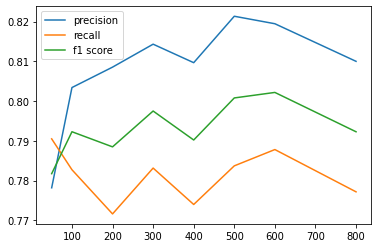

In [39]:
a , p ,r ,f ,m = [], [] , [], [] , []
for n in n_est_tune.values():
    a.append(n['avg_scores']['accuracy'])
    p.append(n['avg_scores']['precision'])
    r.append(n['avg_scores']['recall'])
    f.append(n['avg_scores']['f1'])
    #m.append(n['mcc'])
plt.plot(n_est_tune.keys() , p , label='precision')
plt.plot(n_est_tune.keys() , r , label='recall')
plt.plot(n_est_tune.keys() , f , label='f1 score')
#plt.plot(n_est_tune.keys() , m , label='MCC')
#plt.plot(n_est_tune.keys() , a , label='')
plt.legend()
plt.show()

### Learning Rate

In [41]:
try:
    lr_tune = joblib.load('../not_on_git/lr_tune_dict.pkl')
except:
    lr_tune = {}

In [ ]:
    
for n in [0.01 , 0.05 , 0.1 , 0.15 , 0.20 , 0.25 , 0.30]:
    gamma = 0.07
    cl_weight = calc_weight(gamma , y)
    clf = lgb.LGBMClassifier(n_estimators=80 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True , learning_rate = n)
    model = make_model('lightGBM' , clf ,gamma , x,y)
    model.validate(k=5)
    lr_tune[n] = {
        'avg_scores' : model.result['avg_scores'] ,
        'class_scores' : model.result['class_scores']
    }
    joblib.dump(n_est_tune , '../not_on_git/lr_tune_dict.pkl' , compress=3)


In [52]:
lr_tune[0.25]

{'avg_scores': {'balanced_accuracy': 0.7689957001688149,
  'accuracy': 0.9289887056990783,
  'precision': 0.8059085027346792,
  'recall': 0.7689957001688149,
  'f1': 0.7857888964081075},
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.976200         0.962536  0.969320
 CV          0.560241         0.632653  0.594249
 HMXB        0.897059         0.906757  0.901882
 LMXB        0.776224         0.940678  0.850575
 PULSAR      0.366337         0.425287  0.393617
 STAR        0.955914         0.956943  0.956428
 ULX         0.663507         0.703518  0.682927
 YSO         0.956484         0.918896  0.937313}

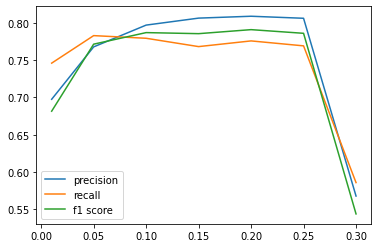

In [51]:
a , p ,r ,f ,m = [], [] , [], [] , []
for n in lr_tune.values():
    a.append(n['avg_scores']['accuracy'])
    p.append(n['avg_scores']['precision'])
    r.append(n['avg_scores']['recall'])
    f.append(n['avg_scores']['f1'])
    #m.append(n['avg_scores']['mcc'])
plt.plot(lr_tune.keys() , p , label='precision')
plt.plot(lr_tune.keys() , r , label='recall')
plt.plot(lr_tune.keys() , f , label='f1 score')
#plt.plot(lr_tune.keys() , m , label='MCC')
#plt.plot(lr_tune.keys() , a , label='')
plt.legend()
plt.show()

# Source Variability

In [53]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


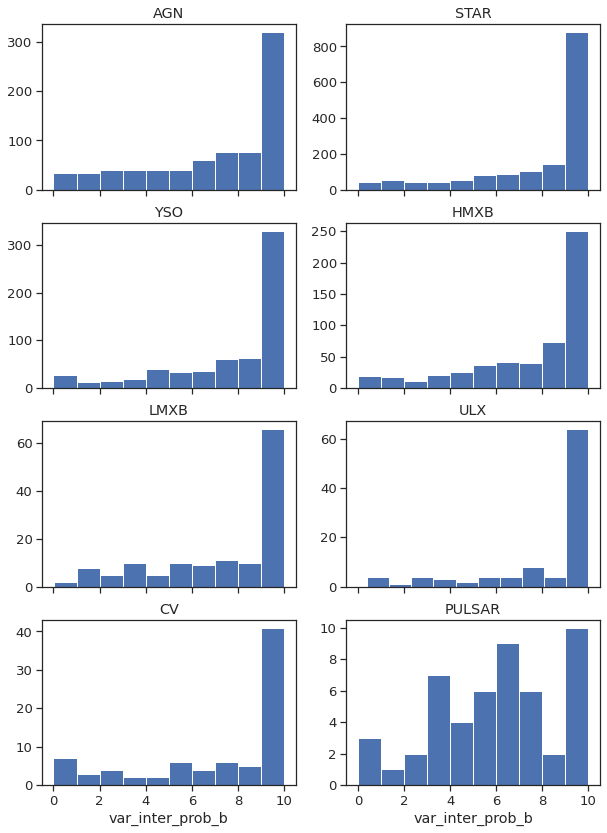

In [86]:
cl = ['AGN' ,'STAR' , 'YSO' , 'HMXB' , 'LMXB' , 'ULX' ,'CV' ,'PULSAR']
sns.set(font_scale=1.2, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':False} , style="ticks")
f = 'kp_intra_prob_b'
f = 'var_inter_prob_b'
fig , ax = plt.subplots(nrows=4, ncols=2 , figsize=(10,14) , sharex=True)
#plt.hist(x['kp_intra_prob_b'])
cl = np.reshape(cl , ax.shape)
for i in range(4):
    for j in range(2):
        temp = x[y==cl[i][j]]
        ax[i][j].hist(temp[f] , label = cl[i][j])
        ax[i][j].set_title(cl[i][j])
        #ax[i][j].legend()
        #ax[i][j].set_xlabel('var_intra_prob_b')
ax[3][0].set_xlabel(f)
ax[3][1].set_xlabel(f)

plt.show()

# Application on Globular Cluster sources

### Find globular cluster source names

### Imports

In [34]:
# Basic numeric and plotting imports

import numpy as np
import scipy

from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors


import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astroquery.vizier import Vizier

import pyvo as vo

from ciao_contrib.runtool import search_csc
from sherpa.astro import ui

ModuleNotFoundError: No module named 'ciao_contrib'

In [39]:
import joblib
from matplotlib import pyplot as plt 
import seaborn as sns 
import numpy as np 
from utilities import make_model
import pandas as pd 

### Cone Search GC

In [12]:
gc = pd.read_csv('temp_files/gc_cat.csv')[['ID' , 'RA(2000)' , 'DEC']]
gc 

,ID,RA(2000),DEC
0,NGC-104,00 24 05.67,-72 04 52.6
1,NGC-288,00 52 45.24,-26 34 57.4
2,NGC-362,01 03 14.26,-70 50 55.6
3,Whiting_1,02 02 57,-03 15 10
4,NG_1261,03 12 16.21,-55 12 58.4
...,...,...,...
152,NGC-7089,21 33 27.02,-00 49 23.7
153,NGC-7099,21 40 22.12,-23 10 47.5
154,Pal-12,21 46 38.84,-21 15 09.4
155,Pal-13,23 06 44.44,+12 46 19.2


In [13]:
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')

In [14]:
help(cone.search)

Help on method search in module pyvo.dal.scs:

search(pos, radius=1.0, verbosity=2, **keywords) method of pyvo.dal.scs.SCSService instance
    submit a simple Cone Search query that requests objects or observations
    whose positions fall within some distance from a search position.
    
    Parameters
    ----------
    pos : astropy.coordinates.SkyCoord
        a SkyCoord instance defining the position of the center of the
        circular search region.
        converted if it's a iterable containing scalars,
        assuming icrs degrees.
    radius : `~astropy.units.Quantity` or float
        a Quantity instance defining the radius of the circular search
        region, in degrees.
        converted if it is another unit.
    verbosity : int
       an integer value that indicates the volume of columns
       to return in the result table.  0 means the minimum
       set of columns, 3 means as many columns as are available.
    **keywords :
       additional case insensitive param

In [16]:
gc[['RA(2000)' , 'DEC']]

,RA(2000),DEC
0,00 24 05.67,-72 04 52.6
1,00 52 45.24,-26 34 57.4
2,01 03 14.26,-70 50 55.6
3,02 02 57,-03 15 10
4,03 12 16.21,-55 12 58.4
...,...,...
152,21 33 27.02,-00 49 23.7
153,21 40 22.12,-23 10 47.5
154,21 46 38.84,-21 15 09.4
155,23 06 44.44,+12 46 19.2


In [24]:
from astropy.coordinates import ICRS, Galactic, FK4, FK5
coords = ["1:12:43.2 +31:12:43", "1 12 43.2 +31 12 43"]
coords = [f'{r} {d}' for r,d in zip(gc['RA(2000)'] ,  gc['DEC'])]
coords = SkyCoord(coords, frame=FK4, unit=(u.hourangle, u.deg),)

In [ ]:
from tqdm import tqdm 
maxrad = 30*u.arcmin
try:
    gc_obj = joblib.load('../not_on_git/gc_objects.pkl')
except:
    gc_obj = {}
for i in tqdm(range(len(gc))[:]):
    try:
        results = cone.search(pos=c[i], radius=maxrad, verbosity=3)
        temp = results.to_table().to_pandas()[['name' ,'ra' ,'dec' , 'err_ellipse_r0' , 'err_ellipse_r1' , 'err_ellipse_ang' , 'gal_b' , 'gal_l']]
        temp = temp.drop_duplicates('name')
        temp.insert(0 , 'gc' , gc['ID'][i])
        gc_obj[gc['ID'][i]] = temp 
        joblib.dump(gc_obj , '../not_on_git/gc_objects.pkl' , compress=3)
    except:
        print(f">> [ERROR]{gc['ID'][i]} could not be done due to some reason")


### Application

#### predict

In [67]:
model = joblib.load('models/lightGBM-final.pkl')
model

In [68]:
clf = model.clf

In [69]:
from choices import param_dict
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )

u = []
ui = []
for i in range(8):
    u.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/x-chunk-{i}.csv' , index_col='name'))
    #ui.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/id-chunk-{i}.csv' , index_col='name'))
u.append(pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name'))
u = pd.concat(u)
#ui = pd.concat(ui)
u = u.drop(columns=feat_to_drop)
u

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J003935.9-732725,2.561951,8.447115,NaN,NaN,2.809762,NaN,8.723285,0.0,4.972998e-06,0.003956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J003936.7-731249,2.548397,8.447672,NaN,NaN,5.267622,NaN,3.246585,0.0,NaN,0.016586,...,8.751645,2.628340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004028.7-731106,2.546591,8.445331,NaN,NaN,2.001693,NaN,2.474462,0.0,NaN,0.124419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004506.3-730056,2.536271,8.432664,NaN,NaN,1.712439,NaN,8.102221,0.0,1.135905e-08,0.027585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J004659.0-731918,2.553126,8.427077,NaN,NaN,2.771679,NaN,3.443930,0.0,7.595018e-09,0.004986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,2.153631,9.602391,6.284069,0.008090,0.848783,5.00,9.398184,0.0,2.267642e-07,0.035677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220508.3-495935,2.148799,9.600738,7.232708,0.007515,7.897757,6.25,9.373067,2.0,8.028243e-08,0.041673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220544.0-495505,2.142337,9.602388,7.905990,0.007822,NaN,6.25,NaN,NaN,1.863801e-07,0.016260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# NO NEED TO RUN
# Handling joblib pkl issue
gc = joblib.load('../not_on_git/gc_objects.pkl')
gc_names = list(gc.keys())
gc_df = []
for g in gc_names:
    gc_df.append(gc[g])
gc_df = pd.concat(gc_df)
gc_df = gc_df.drop_duplicates('name').set_index('name')
gc_df.to_csv('../not_on_git/gc_objects.csv')

In [70]:
gc = pd.read_csv('../not_on_git/gc_objects.csv' ,).drop_duplicates('name').set_index('name')
flags = pd.read_csv('flags/chandra_all_flags.csv' , index_col='name').drop(columns=['ra' ,'dec' , 'gal_l' , 'gal_b'])
gc = pd.merge(gc , flags , left_index=True , right_index=True , how='left')
gc = gc.query('extent_flag==0 and sat_src_flag==0 and pileup_flag==0 and streak_src_flag==0 and conf_flag==0')
gc = gc.drop(columns=['conf_flag' , 'extent_flag' , 'sat_src_flag' , 'pileup_flag' , 'streak_src_flag'])
gc 

,gc,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,gal_b,gal_l,significance,var_flag
name,,,,,,,,,,
2CXO J002108.4-720305,NGC-104,5.285257,-72.051484,11.255965,7.545232,39.876610,-44.882939,306.218312,4.857143,0.0
2CXO J002122.5-720557,NGC-104,5.344140,-72.099279,6.739664,4.864347,27.816042,-44.838786,306.181979,3.142857,0.0
2CXO J002142.4-715957,NGC-104,5.426980,-71.999246,6.584416,3.637067,47.285768,-44.941646,306.169498,5.696970,0.0
2CXO J002202.6-720028,NGC-104,5.511053,-72.007942,9.068593,5.141053,47.606519,-44.937265,306.131299,3.073171,0.0
2CXO J002202.9-720409,NGC-104,5.512213,-72.069178,1.092543,0.954209,100.427752,-44.876883,306.116905,11.988657,0.0
...,...,...,...,...,...,...,...,...,...,...
2CXO J213526.6-010313,NGC-7089,323.860933,-1.053743,1.004113,0.971196,75.692832,-36.312476,53.473404,3.588235,0.0
2CXO J213530.2-010221,NGC-7089,323.876232,-1.039309,2.677642,2.319175,15.482715,-36.317249,53.498824,2.105263,0.0
2CXO J213532.1-005938,NGC-7089,323.884018,-0.994065,4.451708,4.451707,0.000000,-36.298720,53.550948,2.105263,0.0


In [71]:
gc['var_flag'].value_counts()

0.0    1606
1.0     317
Name: var_flag, dtype: int64

In [72]:
u_col = u.columns.to_list()
gc_col = gc.columns.to_list()
u_gc = pd.merge(u , gc.drop(columns=['gal_l' , 'gal_b']) , left_index=True , right_index=True , how='right')[u_col]
u_gc

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J002108.4-720305,2.492853,8.506066,0.714711,0.000149,NaN,0.00,NaN,NaN,3.786501e-10,0.002540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002122.5-720557,2.495316,8.505057,5.952045,0.000306,NaN,3.75,NaN,NaN,2.852202e-11,0.013910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.606553
2CXO J002142.4-715957,2.489578,8.504710,NaN,NaN,0.964701,NaN,5.421957,0.0,4.042095e-09,0.016806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002202.6-720028,2.489822,8.503649,7.906946,0.000213,NaN,6.25,NaN,NaN,1.453227e-10,0.001251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002202.9-720409,2.493191,8.503249,9.163440,0.000309,6.196250,6.25,8.107102,5.0,3.851498e-11,0.012875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J213526.6-010313,2.970978,1.485369,NaN,NaN,3.757147,NaN,0.590202,0.0,1.385145e-08,0.006488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J213530.2-010221,2.970712,1.486075,NaN,NaN,4.999592,NaN,3.689139,0.0,4.772109e-10,0.007222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J213532.1-005938,2.971745,1.487523,NaN,NaN,3.972911,NaN,7.725183,0.0,4.926200e-08,0.003527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
u_gc['gal_b2'].isna().sum()

0

In [75]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u_gc))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u_gc.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J002108.4-720305,0.005297,0.225068,0.018030,6.052695e-05,0.739696,0.010912,7.932550e-04,1.434402e-04
2CXO J002122.5-720557,0.928479,0.021460,0.019168,4.326115e-05,0.008979,0.020471,1.152447e-03,2.474444e-04
2CXO J002142.4-715957,0.034432,0.604475,0.053716,3.856299e-04,0.146329,0.063398,9.713705e-02,1.273056e-04
2CXO J002202.6-720028,0.007795,0.861855,0.032754,2.002283e-04,0.075259,0.019922,1.847734e-03,3.677786e-04
2CXO J002202.9-720409,0.001452,0.934636,0.061682,5.572292e-05,0.001637,0.000194,3.272388e-04,1.662362e-05
...,...,...,...,...,...,...,...,...
2CXO J213526.6-010313,0.031082,0.000477,0.001398,1.020319e-04,0.965468,0.000862,5.705433e-04,4.031213e-05
2CXO J213530.2-010221,0.997933,0.000098,0.000014,8.410442e-07,0.001946,0.000007,3.352657e-07,5.749181e-07
2CXO J213532.1-005938,0.038134,0.001145,0.001521,2.591501e-04,0.320215,0.638110,5.432063e-04,7.169304e-05
2CXO J213533.9-010209,0.726137,0.002336,0.001002,6.339189e-05,0.268587,0.001767,7.321650e-05,3.521438e-05


In [76]:
u_df = pd.DataFrame({
    'name' : u_gc.index.to_list() , 
    'class' : clf.predict(u_gc) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J002108.4-720305,PULSAR,0.739696,0.514628,0.005297,0.225068,0.018030,6.052695e-05,0.739696,0.010912,7.932550e-04,1.434402e-04
2CXO J002122.5-720557,AGN,0.928479,0.907019,0.928479,0.021460,0.019168,4.326115e-05,0.008979,0.020471,1.152447e-03,2.474444e-04
2CXO J002142.4-715957,CV,0.604475,0.458146,0.034432,0.604475,0.053716,3.856299e-04,0.146329,0.063398,9.713705e-02,1.273056e-04
2CXO J002202.6-720028,CV,0.861855,0.786597,0.007795,0.861855,0.032754,2.002283e-04,0.075259,0.019922,1.847734e-03,3.677786e-04
2CXO J002202.9-720409,CV,0.934636,0.872954,0.001452,0.934636,0.061682,5.572292e-05,0.001637,0.000194,3.272388e-04,1.662362e-05
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J213526.6-010313,PULSAR,0.965468,0.934386,0.031082,0.000477,0.001398,1.020319e-04,0.965468,0.000862,5.705433e-04,4.031213e-05
2CXO J213530.2-010221,AGN,0.997933,0.995987,0.997933,0.000098,0.000014,8.410442e-07,0.001946,0.000007,3.352657e-07,5.749181e-07
2CXO J213532.1-005938,STAR,0.638110,0.317896,0.038134,0.001145,0.001521,2.591501e-04,0.320215,0.638110,5.432063e-04,7.169304e-05


In [77]:
gc_pred = pd.merge(gc , u_df , left_index=True , right_index=True)[u_df.columns.to_list()+['gc' ,'ra' ,'dec' ,'significance']]
gc_pred['gc'] = [el[1:] for el in gc_pred['gc']] # to remove spaces in front of gc names
#gc_pred.to_csv('gc_source_predictions.csv')
gc_pred

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO,gc,ra,dec,significance
name,,,,,,,,,,,,,,,
2CXO J002108.4-720305,PULSAR,0.739696,0.514628,0.005297,0.225068,0.018030,6.052695e-05,0.739696,0.010912,7.932550e-04,1.434402e-04,NGC-104,5.285257,-72.051484,4.857143
2CXO J002122.5-720557,AGN,0.928479,0.907019,0.928479,0.021460,0.019168,4.326115e-05,0.008979,0.020471,1.152447e-03,2.474444e-04,NGC-104,5.344140,-72.099279,3.142857
2CXO J002142.4-715957,CV,0.604475,0.458146,0.034432,0.604475,0.053716,3.856299e-04,0.146329,0.063398,9.713705e-02,1.273056e-04,NGC-104,5.426980,-71.999246,5.696970
2CXO J002202.6-720028,CV,0.861855,0.786597,0.007795,0.861855,0.032754,2.002283e-04,0.075259,0.019922,1.847734e-03,3.677786e-04,NGC-104,5.511053,-72.007942,3.073171
2CXO J002202.9-720409,CV,0.934636,0.872954,0.001452,0.934636,0.061682,5.572292e-05,0.001637,0.000194,3.272388e-04,1.662362e-05,NGC-104,5.512213,-72.069178,11.988657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J213526.6-010313,PULSAR,0.965468,0.934386,0.031082,0.000477,0.001398,1.020319e-04,0.965468,0.000862,5.705433e-04,4.031213e-05,NGC-7089,323.860933,-1.053743,3.588235
2CXO J213530.2-010221,AGN,0.997933,0.995987,0.997933,0.000098,0.000014,8.410442e-07,0.001946,0.000007,3.352657e-07,5.749181e-07,NGC-7089,323.876232,-1.039309,2.105263
2CXO J213532.1-005938,STAR,0.638110,0.317896,0.038134,0.001145,0.001521,2.591501e-04,0.320215,0.638110,5.432063e-04,7.169304e-05,NGC-7089,323.884018,-0.994065,2.105263


#### Science

In [78]:
#gc_pred = pd.read_csv('gc_source_predictions.csv' , index_col='name')
gc_pred

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO,gc,ra,dec,significance
name,,,,,,,,,,,,,,,
2CXO J002108.4-720305,PULSAR,0.739696,0.514628,0.005297,0.225068,0.018030,6.052695e-05,0.739696,0.010912,7.932550e-04,1.434402e-04,NGC-104,5.285257,-72.051484,4.857143
2CXO J002122.5-720557,AGN,0.928479,0.907019,0.928479,0.021460,0.019168,4.326115e-05,0.008979,0.020471,1.152447e-03,2.474444e-04,NGC-104,5.344140,-72.099279,3.142857
2CXO J002142.4-715957,CV,0.604475,0.458146,0.034432,0.604475,0.053716,3.856299e-04,0.146329,0.063398,9.713705e-02,1.273056e-04,NGC-104,5.426980,-71.999246,5.696970
2CXO J002202.6-720028,CV,0.861855,0.786597,0.007795,0.861855,0.032754,2.002283e-04,0.075259,0.019922,1.847734e-03,3.677786e-04,NGC-104,5.511053,-72.007942,3.073171
2CXO J002202.9-720409,CV,0.934636,0.872954,0.001452,0.934636,0.061682,5.572292e-05,0.001637,0.000194,3.272388e-04,1.662362e-05,NGC-104,5.512213,-72.069178,11.988657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J213526.6-010313,PULSAR,0.965468,0.934386,0.031082,0.000477,0.001398,1.020319e-04,0.965468,0.000862,5.705433e-04,4.031213e-05,NGC-7089,323.860933,-1.053743,3.588235
2CXO J213530.2-010221,AGN,0.997933,0.995987,0.997933,0.000098,0.000014,8.410442e-07,0.001946,0.000007,3.352657e-07,5.749181e-07,NGC-7089,323.876232,-1.039309,2.105263
2CXO J213532.1-005938,STAR,0.638110,0.317896,0.038134,0.001145,0.001521,2.591501e-04,0.320215,0.638110,5.432063e-04,7.169304e-05,NGC-7089,323.884018,-0.994065,2.105263


In [79]:
from choices import get_train_data
train = get_train_data(offset=1)[['class']]
train

offset:  	0.000|1.010
singinficance:  1.000|267.938


,class
name,
2CXO J002359.4-720438,CV
2CXO J174041.4-534004,CV
2CXO J002409.2-720543,CV
2CXO J002411.1-720620,CV
2CXO J002401.4-720441,CV
...,...
2CXO J003444.5-431554,AGN
2CXO J203606.3+422737,YSO
2CXO J131747.5+411745,AGN


In [80]:
temp = gc_pred.reset_index()
gc_pred_new = temp[~temp['name'].isin(train.index.to_list())].set_index('name')
gc_pred_new

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO,gc,ra,dec,significance
name,,,,,,,,,,,,,,,
2CXO J002108.4-720305,PULSAR,0.739696,0.514628,0.005297,0.225068,0.018030,6.052695e-05,0.739696,0.010912,7.932550e-04,1.434402e-04,NGC-104,5.285257,-72.051484,4.857143
2CXO J002122.5-720557,AGN,0.928479,0.907019,0.928479,0.021460,0.019168,4.326115e-05,0.008979,0.020471,1.152447e-03,2.474444e-04,NGC-104,5.344140,-72.099279,3.142857
2CXO J002142.4-715957,CV,0.604475,0.458146,0.034432,0.604475,0.053716,3.856299e-04,0.146329,0.063398,9.713705e-02,1.273056e-04,NGC-104,5.426980,-71.999246,5.696970
2CXO J002202.6-720028,CV,0.861855,0.786597,0.007795,0.861855,0.032754,2.002283e-04,0.075259,0.019922,1.847734e-03,3.677786e-04,NGC-104,5.511053,-72.007942,3.073171
2CXO J002202.9-720409,CV,0.934636,0.872954,0.001452,0.934636,0.061682,5.572292e-05,0.001637,0.000194,3.272388e-04,1.662362e-05,NGC-104,5.512213,-72.069178,11.988657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J213526.6-010313,PULSAR,0.965468,0.934386,0.031082,0.000477,0.001398,1.020319e-04,0.965468,0.000862,5.705433e-04,4.031213e-05,NGC-7089,323.860933,-1.053743,3.588235
2CXO J213530.2-010221,AGN,0.997933,0.995987,0.997933,0.000098,0.000014,8.410442e-07,0.001946,0.000007,3.352657e-07,5.749181e-07,NGC-7089,323.876232,-1.039309,2.105263
2CXO J213532.1-005938,STAR,0.638110,0.317896,0.038134,0.001145,0.001521,2.591501e-04,0.320215,0.638110,5.432063e-04,7.169304e-05,NGC-7089,323.884018,-0.994065,2.105263


In [ ]:
# DO NOT RUN
from tqdm import tqdm
for n in tqdm(gc_pred['gc'].unique()[:]):
    gca = gc_pred[gc_pred['gc']==n]
    #plt.hist(gca['prob'])
    #plt.show()
    fig , ax = plt.subplots(nrows=1, ncols=2 , figsize=(10,4)) 
    sns.scatterplot(
        #data=gca[gca['prob']>0.9] ,
        data = gca ,
        x='ra', y='dec', hue='class' , alpha=1 , 
        ax = ax[0]
        )
    sns.scatterplot(
        data=gca[gca['prob']>0.9] ,
        #data = gca ,
        x='ra', y='dec', hue='class' , alpha=1 , 
        ax = ax[1]
        )
    plt.title(n)
    plt.savefig(f'temp_files/gc_plots/{n}_gc_plots.jpg')
    plt.close()
#plt.show()

##### Class counts

In [83]:
gca = gc_pred[gc_pred['gc']=='NGC-104']


In [85]:
print(
    pd.merge(
    gca['class'].value_counts().to_frame('All predictions') , 
    gca[gca['prob']>0.9]['class'].value_counts().to_frame('Prediction with Prob > 0.9') , 
    left_index=True , 
    right_index =True , 
    how='left'
    ).to_markdown()
)
#gca[gca['prob']>0.9]

|        |   All predictions |   Prediction with Prob > 0.9 |
|:-------|------------------:|-----------------------------:|
| PULSAR |               196 |                          110 |
| CV     |               117 |                           57 |
| STAR   |                43 |                           27 |
| HMXB   |                 6 |                          nan |
| ULX    |                 3 |                          nan |
| AGN    |                 3 |                            1 |


##### plot sources

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


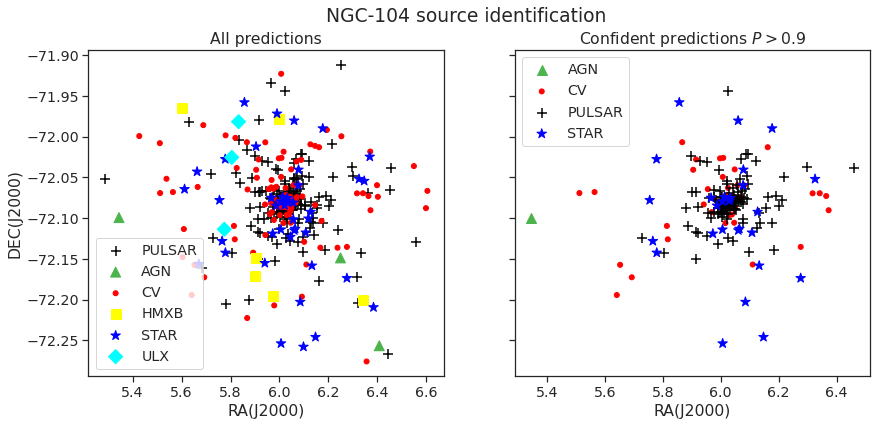

In [88]:
gca = gc_pred[gc_pred['gc']=='NGC-104']
sns.set(font_scale=1.3, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':False} , style="ticks")

fig , ax = plt.subplots(nrows=1, ncols=2 , figsize=(14,6) , sharey=True) 
for c in gca['class'].unique():
    temp = gca[gca['class']==c].sort_values(by='class')
    rgba_colors = np.zeros((len(temp),3))
    # for red the first column needs to be one
    if(c=='CV'):
        rgba_colors[:,0] = 1
        marker='.'
    elif(c=='AGN'):
        rgba_colors[:,0] = 0.3
        rgba_colors[:,1] = 0.7
        rgba_colors[:,2] = 0.3
        marker='^'
    elif(c=='HMXB'):
        rgba_colors[:,0] = 1
        rgba_colors[:,1] = 1
        marker='s'
    elif(c=='STAR'):
        #rgba_colors[:,0] = 1
        rgba_colors[:,2] = 1
        marker = '*'
    elif(c=='PULSAR'):
        rgba_colors[:,0] = 0
        rgba_colors[:,1] = 0
        rgba_colors[:,2] = 0
        marker = '+'
    elif(c=='ULX'):
        rgba_colors[:,0] = 0
        rgba_colors[:,1] = 1
        rgba_colors[:,2] = 1
        marker = 'D'
    #rgba_colors[:, 3] = temp['prob']
    ax[0].scatter(temp['ra'] , temp['dec']  , label=c , marker=marker , s=100 , color = rgba_colors)
ax[0].legend()
g = gca[gca['prob']>0.9]
for c in g['class'].unique():
    temp = g[g['class']==c].sort_values(by='class')
    rgba_colors = np.zeros((len(temp),3))
    # for red the first column needs to be one
    if(c=='CV'):
        rgba_colors[:,0] = 1
        marker='.'
    elif(c=='AGN'):
        rgba_colors[:,0] = 0.3
        rgba_colors[:,1] = 0.7
        rgba_colors[:,2] = 0.3
        marker='^'
    elif(c=='HMXB'):
        rgba_colors[:,0] = 1
        rgba_colors[:,1] = 1
        marker='s'
    elif(c=='STAR'):
        #rgba_colors[:,0] = 1
        rgba_colors[:,2] = 1
        marker = '*'
    elif(c=='PULSAR'):
        rgba_colors[:,0] = 0
        rgba_colors[:,1] = 0
        rgba_colors[:,2] = 0
        marker = '+'
    elif(c=='ULX'):
        rgba_colors[:,0] = 0
        rgba_colors[:,1] = 1
        rgba_colors[:,2] = 1
        marker = 'D'
    #rgba_colors[:, 3] = temp['prob']
    ax[1].scatter(temp['ra'] , temp['dec']  , label=c , marker=marker , s=100 , color = rgba_colors)
    # the fourth column needs to be your alphas
ax[1].legend()
ax[0].set_title('All predictions')
ax[1].set_title('Confident predictions $P > 0.9$')
fig.suptitle('NGC-104 source identification')
ax[0].set_xlabel('RA(J2000)')
ax[1].set_xlabel('RA(J2000)')
ax[0].set_ylabel('DEC(J2000)')
plt.savefig('final_plots/ngc-104-pred.eps' , format='eps')
plt.show()

##### SED for AGN

In [37]:
sed = pd.read_csv('temp_files/agn-hgc-104.csv').drop_duplicates('Frequency')
sed

,Frequency,Flux Density,NED Uncertainty
0,9.190000e+17,NaN,<3.35E-11
4,5.560000e+17,2.120000e-09,+/-6.36E-10
8,3.770000e+17,4.910000e-10,+/-1.74E-10
12,2.220000e+17,4.370000e-10,+/-1.37E-10
16,9.670000e+16,8.790000e-09,+/-4.13E-09
20,8.940000e+13,7.340000e-05,+/-5.68E-06
23,6.510000e+13,NaN,<3.95E-04
26,2.590000e+13,NaN,<3.98E-04
29,1.360000e+13,NaN,<3.13E-03


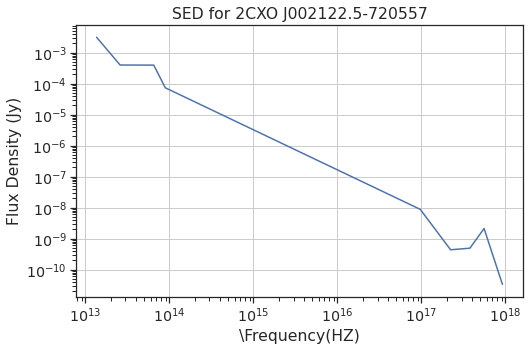

In [53]:
flux = [3.35E-11 ,2.120000e-09 , 4.910000e-10	 ,  4.370000e-10 , 8.790000e-09 , 7.340000e-05 , 3.95E-04 , 3.98E-04 , 3.13E-03	]
plt.figure(figsize=(8,5))
plt.loglog(sed['Frequency'] , flux)
plt.xlabel('\Frequency(HZ)')
plt.ylabel('Flux Density (Jy)')
plt.title('SED for 2CXO J002122.5-720557')
plt.grid()
plt.savefig('final_plots/agn-sed.eps' , format='eps')
plt.show()

In [75]:
gca[gca['prob_margin']<0.03]

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO,gc,ra,dec,significance
name,,,,,,,,,,,,,,,
2CXO J002224.3-715752,HMXB,0.403644,0.015498,0.388146,0.071404,0.403644,0.000966,0.076034,0.007577,0.048929,0.003300,NGC-104,5.601639,-71.964661,5.485714
2CXO J002243.5-720939,PULSAR,0.410370,0.020552,0.003337,0.389818,0.168779,0.000517,0.410370,0.025543,0.000895,0.000742,NGC-104,5.681441,-72.160983,3.263158
2CXO J002339.7-715846,PULSAR,0.492429,0.025113,0.001956,0.467317,0.032923,0.000068,0.492429,0.003686,0.001452,0.000168,NGC-104,5.915697,-71.979674,3.687500
2CXO J002352.1-715601,PULSAR,0.491782,0.007313,0.002371,0.484469,0.017633,0.000039,0.491782,0.001781,0.001801,0.000125,NGC-104,5.967384,-71.933800,6.523275
2CXO J002359.2-715843,HMXB,0.344810,0.020867,0.003495,0.323944,0.344810,0.000445,0.300993,0.022054,0.003867,0.000392,NGC-104,5.996899,-71.978820,3.812500
2CXO J002408.5-720708,PULSAR,0.396774,0.007833,0.002958,0.388941,0.098778,0.000597,0.396774,0.107769,0.003131,0.001050,NGC-104,6.035810,-72.119018,3.945946
2CXO J002422.0-721146,CV,0.457986,0.002226,0.001619,0.457986,0.053042,0.000060,0.455760,0.006505,0.024905,0.000123,NGC-104,6.091817,-72.196315,3.729730


In [76]:
gca[gca['class']=='HMXB']

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO,gc,ra,dec,significance
name,,,,,,,,,,,,,,,
2CXO J002224.3-715752,HMXB,0.403644,0.015498,0.388146,0.071404,0.403644,0.000966,0.076034,0.007577,0.048929,0.003300,NGC-104,5.601639,-71.964661,5.485714
2CXO J002336.2-721016,HMXB,0.678455,0.480458,0.005159,0.114193,0.678455,0.000245,0.197997,0.002928,0.000659,0.000365,NGC-104,5.900900,-72.171387,4.606061
2CXO J002337.2-720854,HMXB,0.528545,0.146235,0.004087,0.382310,0.528545,0.001260,0.049212,0.032661,0.001424,0.000500,NGC-104,5.905234,-72.148466,5.058824
2CXO J002359.2-715843,HMXB,0.344810,0.020867,0.003495,0.323944,0.344810,0.000445,0.300993,0.022054,0.003867,0.000392,NGC-104,5.996899,-71.978820,3.812500
2CXO J002522.1-721201,HMXB,0.563637,0.262871,0.015896,0.022753,0.563637,0.000341,0.025087,0.071212,0.300765,0.000308,NGC-104,6.342294,-72.200403,4.812500


##### radial distribution